---
# **Augmentation on the comma10k Dataset**
---

**Imports**

In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from pathlib import Path
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import datetime
from IPython.display import clear_output, display
from base64 import b64encode
from IPython.display import HTML

**Device and Directory**

In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset paths
images_dir = "C:/Users/matvell/Downloads/comma10k/comma10k/images/"
masks_dir = "C:/Users/matvell/Downloads/comma10k/comma10k/masks/"

**Dataset**

In [3]:
# Initialize constants
IMG_SIZE = 512
N_CHANNELS = 3
N_CLASSES = 1
BATCH_SIZE = 1
SEED = 2000

# Set random seed for reproducibility
torch.manual_seed(SEED)

class Comma10kDataset(Dataset):
    def __init__(self, images_dir, masks_dir, img_format="*.png", mask_format="*.png", transform=None):
        self.img_files = sorted(list(Path(images_dir).glob(img_format)))
        self.mask_files = sorted(list(Path(masks_dir).glob(mask_format)))
        self.transform = transform

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        image = Image.open(self.img_files[idx]).convert("RGB")
        mask = Image.open(self.mask_files[idx]).convert("RGB")

        # Resize the image and mask
        image = image.resize((IMG_SIZE, IMG_SIZE))
        mask = mask.resize((IMG_SIZE, IMG_SIZE))

        # Convert the mask to binary using road and lane marking labels
        mask, dilated_mask, difference_mask = self.binary_encode_mask(np.array(mask))

        # Apply transformations to the image (mask is already a numpy array and doesn't need transform)
        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for mask

        return image, mask, dilated_mask, difference_mask
    
    def binary_encode_mask(self, mask_array):
        # Define the RGB labels
        road_label = np.array([64, 32, 32])       # road
        lane_label = np.array([255, 0, 0])        # lane markings

        # Create the road and lane masks
        road_mask = np.all(mask_array == road_label, axis=-1)
        lane_mask = np.all(mask_array == lane_label, axis=-1)

        # Save the original lane mask for visualization before dilation
        original_lane_mask = lane_mask.astype(np.uint8)

        # Dilate the lane mask to remove the boundary issues
        kernel = np.ones((5, 5), np.uint8)
        dilated_lane_mask = cv2.dilate(lane_mask.astype(np.uint8), kernel, iterations=1)

        # Combine the road and dilated lane masks
        binary_mask = np.logical_or(road_mask, dilated_lane_mask).astype(np.uint8)

        # Compute the difference between the original and dilated lane masks
        difference_mask = dilated_lane_mask - original_lane_mask

        return binary_mask, dilated_lane_mask, difference_mask

**Pre-processing and Loading**

In [4]:
# Define the transformation
transform = transforms.Compose([transforms.ToTensor()])

# Create datasets
train_dataset = Comma10kDataset(images_dir, masks_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

**Data Augmentation (Morphological Dilation)**

Image Shape: torch.Size([1, 3, 512, 512])
Mask Shape: torch.Size([1, 1, 512, 512])


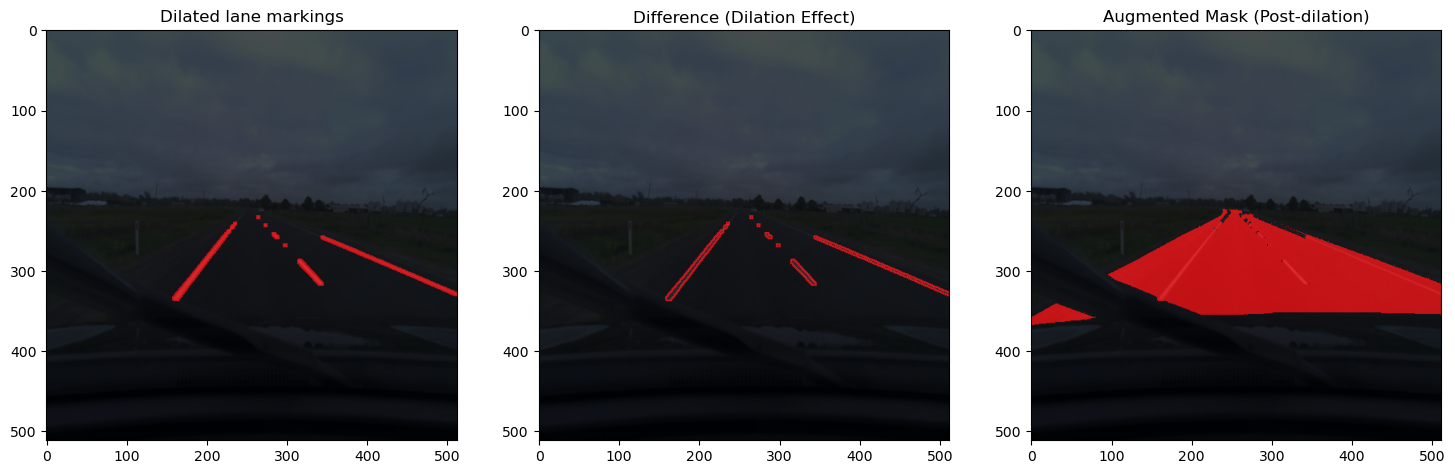

In [5]:
# Function to overlay mask on image
def overlay_mask_on_image(image, mask, alpha=0.7):
    # Move the image and mask to the CPU and detach from the computation graph
    image = image.cpu().detach()
    mask = torch.tensor(mask).cpu().detach() if not torch.is_tensor(mask) else mask.cpu().detach()

    # Ensure mask is 2D for overlay
    if mask.dim() == 3 and mask.size(0) == 1:
        mask = mask.squeeze(0)

    # Normalize image to be in the range [0, 1]
    image = image.permute(1, 2, 0)  
    image = (image - image.min()) / (image.max() - image.min())

    # Convert the mask to RGB for overlaying
    mask_rgb = torch.stack([mask, torch.zeros_like(mask), torch.zeros_like(mask)], dim=-1)

    # Overlay mask onto the image
    overlay = (1 - alpha) * image + alpha * mask_rgb

    return overlay

# Function to visualize lane marking dilation with overlay
def visualize_lane_marking_dilation(image, original_lane_mask, dilated_lane_mask, difference_mask):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Squeeze to ensure the masks are 2D
    original_lane_mask = np.squeeze(original_lane_mask)
    dilated_lane_mask = np.squeeze(dilated_lane_mask)
    difference_mask = np.squeeze(difference_mask)

    # Overlay original, dilated, and difference masks on the image
    original_overlay = overlay_mask_on_image(image, original_lane_mask)
    dilated_overlay = overlay_mask_on_image(image, dilated_lane_mask)
    difference_overlay = overlay_mask_on_image(image, difference_mask)

    # Dilated lane markings
    ax[0].imshow(dilated_overlay)
    ax[0].set_title('Dilated lane markings')

    # Dilation Difference from the Original Mask
    ax[1].imshow(difference_overlay)
    ax[1].set_title('Difference (Dilation Effect)')

    # Final Augmented Mask
    ax[2].imshow(original_overlay)
    ax[2].set_title('Augmented Mask (Post-dilation)')

    plt.show()

# Function to merge difference mask with road/lane combined mask to create final mask
def merge_masks(road_lane_mask, difference_mask):
    # Merge the difference mask into the road/lane mask
    final_mask = np.logical_or(road_lane_mask, difference_mask).astype(np.uint8)
    return final_mask

# Display a sample from the dataset and visualize dilation effect
for images, road_lane_masks, dilated_masks, difference_masks in train_loader:
    print(f"Image Shape: {images.shape}") 
    print(f"Mask Shape: {road_lane_masks.shape}")

    # Convert torch tensors to numpy for visualization
    road_lane_mask_np = road_lane_masks.squeeze(0).cpu().numpy()
    dilated_mask_np = dilated_masks.cpu().numpy()
    difference_mask_np = difference_masks.cpu().numpy()

    # Merge the masks to get the final mask
    final_mask = merge_masks(road_lane_mask_np, difference_mask_np)

    # Visualize the original, dilated, and difference masks with overlay
    visualize_lane_marking_dilation(images[0], road_lane_mask_np, dilated_mask_np, difference_mask_np)

    break   # Break after first batch
